In [3]:
import numpy as np
import pandas as pd
import datetime
import time
from demand_model import *
import pywt
from utils import *
from uncertainty_process import *
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

## create DemandFile object, get basic date from it, date, date_ud, cusid, cusid_ud, and dataframe
Demandbase = DemandFile('SelectedDataFor1EE.xlsx', 'Sheet1')
Date = Demandbase.getDate()
Date_ud = Demandbase.getDate_ud()
CusID = Demandbase.getCusID()
CusID_ud = Demandbase.getCusID_ud()

In [4]:
def inlist(dm,CLT):
    idbase = (dm['CustomerID'] == 0)
    for ind in CLT:
        tmpid = (dm['CustomerID'] == ind)
        idbase = idbase | tmpid
    return idbase
def rateCal(mlist):
    ori = np.mean(mlist[:-1])
    new = mlist[-1]
    rate = (ori - new)/ori
    return rate

In [5]:
import random
## setting data use parameters, set customers and dates which is taken into consideration
modset_c = ['fixed','period','list']
modset_d = ['fixed','period','list']
Cus = 1002
CusStart = 1002
CusEnd = 2000
Date = '2009-07-14' # this is a Monday
DateStart = '2009-07-14'#'2009-07-14'#'2009-09-04' ## including
DateEnd = '2009-07-21' ## not including, start from friday, then end on friday
DateList = ['2009-07-14', '2009-07-19']
time1 = time.time()

In [68]:
# all load profiles
DCL = 3 # decomposition level
## setting mode and get considering data
mod_c = 'list'
mod_d = 'period'
agmod = 'mean'
## initiate database
Demand = Demandbase.getDataframeAll()
indlist = random.sample(range(0,929), 100)
indlist = np.sort(indlist)
CusList = []
for i_ind in indlist:
    CusList.append(CusID_ud[i_ind])
# get data which comply with customer id conditions first, use switch code
for case in switch(mod_c):
    if case('fixed'):
        Demand = Demand[(Demand['CustomerID'] == Cus)]
        break
    if case('period'):
        Demand = Demand[(Demand['CustomerID'] >= CusStart) & (Demand['CustomerID'] < CusEnd)]
        break
    if case('list'):
        ils = inlist(Demand, CusList)
        Demand = Demand[inlist(Demand, CusList)]
        break
    if case():
        print "mod_c setting error #1"

# get data which comply with date condition, then left only data comply with both cusid and date
for case in switch(mod_d):
    if case('fixed'):
        Demand = Demand[(Demand['Date'] == Date)]
        break
    if case('period'):
        Demand = Demand[(Demand['Date'] >= DateStart) & (Demand['Date'] < DateEnd)]
        break
    if case('list'):
        Demand = Demand[(Demand['Date'] in DateList)]
        break
    if case():# default, could also just omit condition or 'if True'
        print "mod_d setting error #2"
        # No need to break here, it'll stop anyway
Demand0 = Demand[(Demand['CustomerID'] == CusStart)]
Demand0['CustomerID'] = 1000
db = np.array(Demand)[:,2:] ## selected N customers load profiles
#print db.shape
cuscount = len(indlist)
#print cuscount
db1 = db.reshape((cuscount, -1))
db2_mean = np.mean(db1, axis = 0)
db2_sum = np.sum(db1, axis = 0)
db3_mean = db2_mean.reshape((-1, 48))
db3_sum = db2_sum.reshape((-1,48))
if agmod == 'mean':
    db3 = db2_mean.reshape((-1, 48))
else: 
    db3 = db2_sum.reshape((-1,48))    
aggregated_load = db3
days = db3.shape[0]
#print days

In [69]:
print pd.DataFrame(Demand).to_csv('data_10_households')

None


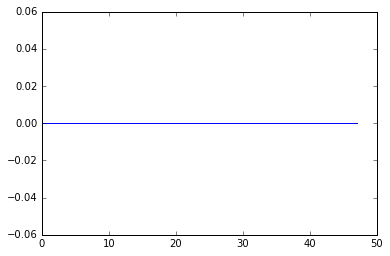

In [70]:
ipt0 = Demand
inputs = np.array(ipt0)[:,2:]
ipt = inputs[0]
wc = WaveletClass(ipt, 'haar', 'constant', 4)
wc.decompose()
(tmp1, tmp2, tmp3) = wc.get_uncertainty(3)
tmpuc = wc.get_uccomp()
plot(range(48), tmp1 + tmp2 + tmp3 - tmpuc)

In [71]:
def get_raw_uncertainty2(inputs, DCL):
    uc1 = []
    uc2 = []
    uc3 = []
    uc = []
    for ipt in inputs:
        wc = WaveletClass(ipt, 'haar', 'constant', 4)
        wc.decompose()
        (tmp1, tmp2, tmp3) = wc.get_uncertainty(3)
        tmpuc = wc.get_uccomp()
        uc1.append(tmp1)
        uc2.append(tmp2)
        uc3.append(tmp3)
        uc.append(tmpuc)
    uc1 = np.array(uc1)
    uc2 = np.array(uc2)
    uc3 = np.array(uc3)
    uc = np.array(uc)
    return [uc1, uc2, uc3, uc]
oucmat1 = []
oucmat2 = []
oucmat3 = []
oucmat = []
for cusind in indlist:
    cus = CusID_ud[cusind]
    inputframe = Demand[(Demand['CustomerID'] == cus)]
    inputs = np.array(inputframe)[:,2:]
    [tmp1, tmp2, tmp3, tmp] = get_raw_uncertainty2(inputs, DCL)
    oucmat.append(tmp)
    oucmat1.append(tmp1)
    oucmat2.append(tmp2)
    oucmat3.append(tmp3)

decompose component d1 shape:  (100, 7, 48)
original demand shape:  (100, 7, 48)
original aggregated demand shape:  (48,)
(100, 7, 48)
(48,)


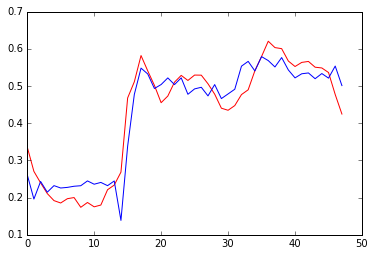

In [72]:
d1 = np.array(oucmat1)
d2 = np.array(oucmat2)
d3 = np.array(oucmat3)
print 'decompose component d1 shape: ',d1.shape
oriDe = db1.reshape([db1.shape[0], -1, 48])
print 'original demand shape: ',oriDe.shape
oriAg = np.mean(oriDe.reshape([-1,48]), axis = 0)
print 'original aggregated demand shape: ', oriAg.shape
newDe = oriDe - d3 - d2
print newDe.shape
if newDe[0,0,0] == oriDe[0,0,0] - d3[0,0,0]:
    print 'substraction correct'
newAg = np.mean(newDe.reshape([-1,48]), axis = 0)
print newAg.shape
#plot first day demand, d1,d2,d3
"""
plot(range(48), oriDe[0,0,:],'black')
plot(range(48), d1[0,0,:],'r')
plot(range(48), d3[0,0,:],'b')
plot(range(48), newDe[0,0,:],'gray')
"""
plot(range(48), oriAg, 'r')
plot(range(48), newAg, 'b')

[[[-0.064   0.064   0.034  -0.034   0.026  -0.026  -0.004   0.004  -0.0265
    0.0265 -0.012   0.012   0.0155 -0.0155  0.0275 -0.0275 -0.0115  0.0115
   -0.019   0.019   0.0085 -0.0085 -0.6675  0.6675 -0.276   0.276   0.514
   -0.514  -0.585   0.585   0.089  -0.089   0.0255 -0.0255  0.103  -0.103
    0.0015 -0.0015 -0.023   0.023  -0.027   0.027  -0.0135  0.0135  0.0135
   -0.0135  0.0275 -0.0275]]]
Success, reduce low resolution uncertainty can make new demand has no 
low resolution uncertainty components, try, aggregated demand


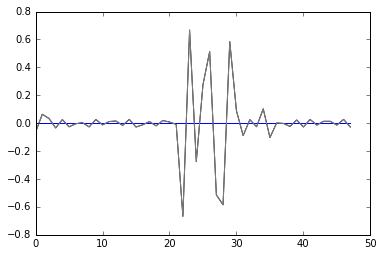

In [73]:
# see if substract low resolution uncertainty can reduce the overall uncertainty
# just for one day, decompose newDe
a = newDe[0:1,0:1,:]
[newtmp1, newtmp2, newtmp3, newtmp] = get_raw_uncertainty2(a, DCL)
print newtmp1
plot(range(48), newtmp1[0,0,:],'black')
plot(range(48), newtmp2[0,0,:],'r')
plot(range(48), newtmp3[0,0,:],'b')
plot(range(48), newtmp[0,0,:],'gray')
print 'Success, reduce low resolution uncertainty can make new demand has no \n\
low resolution uncertainty components, try, aggregated demand'

high resolution compare, red to blue after reduce low resolution


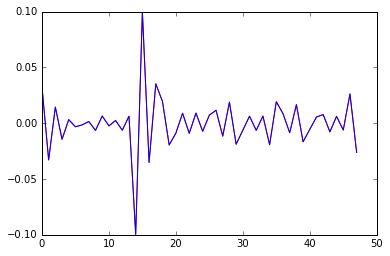

In [74]:
# decompose original load and new load and make the comparison
wcori = WaveletClass(oriAg, 'haar', 'constant', 4)
wcnew = WaveletClass(newAg, 'haar', 'constant', 4)
wcori.decompose()
wcnew.decompose()
(oritmp1, oritmp2, oritmp3) = wcori.get_uncertainty(3)
(newtmp1, newtmp2, newtmp3) = wcnew.get_uncertainty(3)
print 'high resolution compare, red to blue after reduce low resolution'
plot(range(48), oritmp1, 'r')
plot(range(48), newtmp1, 'b')

mid resolution compare, red to blue after reduce low resolution


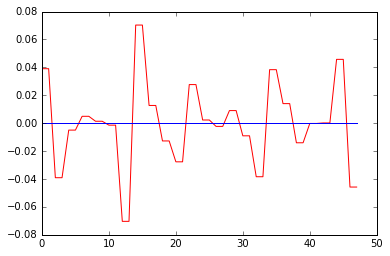

In [75]:
print 'mid resolution compare, red to blue after reduce low resolution'
plot(range(48), oritmp2, 'r')
plot(range(48), newtmp2, 'b')

low resolution compare, red to blue after reduce low resolution
result, reduce low resolution levels ,can reduce the uncertainty components, and new decomposition not exists the component


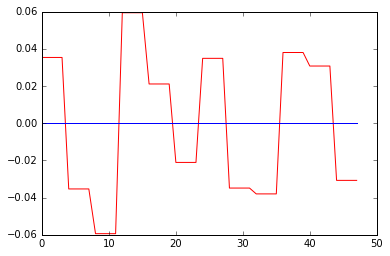

In [76]:
print 'low resolution compare, red to blue after reduce low resolution'
plot(range(48), oritmp3, 'r')
plot(range(48), newtmp3, 'b')
print 'result, reduce low resolution levels ,can reduce the uncertainty components, and new decomposition not exists the component'

In [212]:
# start the optimization part, first define parameters of the optimization
# battery parameters: ....
price = np.array(pd.read_csv('pr.csv'))
#define parameters of battery storage and programming
SoCini = 0
SoCmin = 0.3-0.5
SoCmax = 0.9-0.5
Batcap = 12  # kWh
Pmax = 1.5
Pmin = 0-1.5
Efc = 0.99
Efd = 0.9
T = 0.5
HomePG = 5 # home and grid max power
penetration_rate = 0.20

In [213]:
import scipy.optimize as opt
def optim(demand):
    # OBJ
    def obj(x): # obj = price * Time_duration * (Pt + demand)
        part1 = np.dot(price.T, x + demand)*T
        ret = np.sum(part1)
        return ret
    # CONS 1: # Pt >= P_discharge_limit
    def con1(x): 
        return x - Pmin
    # CONS 2: # Pt <= P_charge_limit
    def con2(x): 
        return Pmax - x
    # CONS 3: # Et >= Emin, Einit = 0.5*cap, Elast = 0.5*cap
    Emin = np.ones(48)*Batcap*SoCmin
    Emin[-1] = 0
    Emax = 0 - Emin
    # define Energy function
    def Energy(x):
        a = np.ones((48,48))
        lower_tri = np.tril(a, k=0)
        Ene = np.matmul(lower_tri,x)*T
        return Ene
    def con3(x):
        return Energy(x) - Emin
    def con4(x):
        return Emax - Energy(x)
    # do not sell energy, that is lose energy is bad
    def con5(x):
        return demand + x
    # max power of the home, or grid
    def con6(x):
        return HomePG - demand - x
    # constraints list
    cons = ({'type': 'ineq', 'fun': con1},
           {'type': 'ineq', 'fun': con2},
           {'type': 'ineq', 'fun': con3},
           {'type': 'ineq', 'fun': con4},
           {'type': 'ineq', 'fun': con5},
           {'type': 'ineq', 'fun': con6})
    x0 = np.zeros(48)  # pick any starting point
    res = opt.minimize(fun=obj, x0=np.array(x0), method='cobyla', constraints=cons, options={'catol': 1e-6})
    return res
def optim2(demand, change, limit):
    # OBJ
    def obj(x): # obj = price * Time_duration * (Pt + demand)
        part1 = np.abs(x + change)
        ret = np.sum(part1)
        return ret
    # CONS 1: # Pt >= P_discharge_limit
    def con1(x): 
        return x - Pmin
    # CONS 2: # Pt <= P_charge_limit
    def con2(x): 
        return Pmax - x
    # CONS 3: # Et >= Emin, Einit = 0.5*cap, Elast = 0.5*cap
    Emin = np.ones(48)*Batcap*SoCmin
    Emin[-1] = 0
    Emax = 0 - Emin
    # define Energy function
    def Energy(x):
        a = np.ones((48,48))
        lower_tri = np.tril(a, k=0)
        Ene = np.matmul(lower_tri,x)*T
        return Ene
    def con3(x):
        return Energy(x) - Emin
    def con4(x):
        return Emax - Energy(x)
    # do not sell energy, that is lose energy is bad
    def con5(x):
        return demand + x
    # max power of the home, or grid
    def con6(x):
        return HomePG - demand - x
    def con7(x):
        part1 = np.dot(price.T, x + demand)*T
        ret = np.sum(part1)
        return limit - ret
    # constraints list
    cons = ({'type': 'ineq', 'fun': con1},
           {'type': 'ineq', 'fun': con2},
           {'type': 'ineq', 'fun': con3},
           {'type': 'ineq', 'fun': con4},
           {'type': 'ineq', 'fun': con5},
           {'type': 'ineq', 'fun': con6},
           {'type': 'ineq', 'fun': con7})
    x0 = np.zeros(48)  # pick any starting point
    res = opt.minimize(fun=obj, x0=np.array(x0), method='cobyla', constraints=cons, options={'catol': 1e-6})
    return res
def optim3(demand, limit):
    # OBJ
    def obj(x): # obj = price * Time_duration * (Pt + demand)
        ret = np.std(x + demand)
        return ret
    # CONS 1: # Pt >= P_discharge_limit
    def con1(x): 
        return x - Pmin
    # CONS 2: # Pt <= P_charge_limit
    def con2(x): 
        return Pmax - x
    # CONS 3: # Et >= Emin, Einit = 0.5*cap, Elast = 0.5*cap
    Emin = np.ones(48)*Batcap*SoCmin
    Emin[-1] = 0
    Emax = 0 - Emin
    # define Energy function
    def Energy(x):
        a = np.ones((48,48))
        lower_tri = np.tril(a, k=0)
        Ene = np.matmul(lower_tri,x)*T
        return Ene
    def con3(x):
        return Energy(x) - Emin
    def con4(x):
        return Emax - Energy(x)
    # do not sell energy, that is lose energy is bad
    def con5(x):
        return demand + x
    # max power of the home, or grid
    def con6(x):
        return HomePG - demand - x
    def con7(x):
        part1 = np.dot(price.T, x + demand)*T
        ret = np.sum(part1)
        return limit - ret
    # constraints list
    cons = ({'type': 'ineq', 'fun': con1},
           {'type': 'ineq', 'fun': con2},
           {'type': 'ineq', 'fun': con3},
           {'type': 'ineq', 'fun': con4},
           {'type': 'ineq', 'fun': con5},
           {'type': 'ineq', 'fun': con6},
           {'type': 'ineq', 'fun': con7})
    x0 = np.zeros(48)  # pick any starting point
    res = opt.minimize(fun=obj, x0=np.array(x0), method='cobyla', constraints=cons, options={'catol': 1e-6})
    return res
def cal_network_uc(GL):
    umlist = []
    tmp1 = uc_process(GL, DCL)
    umlist.append(UncertaintyModel(1,tmp1))
    def uc_analysis(UMList):
        meanlist1 = []
        meanlist2 = []
        meanlist3 = []
        datelist1 = []
        datelist2 = []
        datelist3 = []
        tpntlist1 = []
        tpntlist2 = []
        tpntlist3 = []
        ucmlist = []
        ucdlist = []
        uctlist = []
        count = len(UMList)
        for ind in range(count):
            lv = UMList[ind].getlv()
            if lv == 3:
                (mean1, mean2, mean3, date1, date2, date3, tpnt1, tpnt2, tpnt3, ucm, ucd, uct) = UMList[ind].getuc()
                meanlist1.append(mean1)
                meanlist2.append(mean2)
                meanlist3.append(mean3)
                datelist1.append(date1)
                datelist2.append(date2)
                datelist3.append(date3)
                tpntlist1.append(tpnt1)
                tpntlist2.append(tpnt2)
                tpntlist3.append(tpnt3)
                ucmlist.append(ucm)
                ucdlist.append(ucd)
                uctlist.append(uct)
        return (meanlist1,meanlist2,meanlist3,datelist1,datelist2,datelist3,tpntlist1,tpntlist2,tpntlist3, ucmlist, ucdlist, uctlist)

    (meanlist1,meanlist2,meanlist3,datelist1,datelist2,datelist3,tpntlist1,tpntlist2,tpntlist3, ucmlist, ucdlist, uctlist) = uc_analysis(umlist)
    #meanlist1 # for 5 cus, 4 days, only 5 values for each cus, draw line chart in single figure
    #datelist1 # for 5 cus, 4 days, 5 X 4 matrix, draw 2d surface figure to show, and 3 level in single figure, and also average along customers, to find uc in different dates
    #tpntlist1 # for 5 cus, 4 days, 5 X 48 matrix, draw 2d surface figure to show, and 3 level in single figure, and also average along custoemrs, to find uc in different time points
    print 'Original network uncertainty: ',ucmlist[0]
    return ucmlist[0]

original cost:  1864.20693
new cost:  1724.80649
new cost2:  1766.626622
new cost3:  1766.626622
prior EMS: reducing cost by:  139.40044
new EMS: reducing cost by:  97.580308
smoooth EMS: reducing cost by:  97.580308
load profiles demonstration
----print all daily LPs and the mean LP


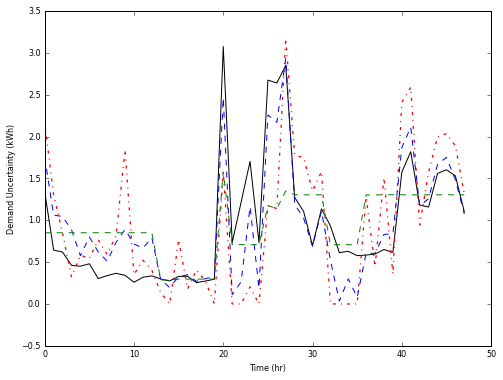

In [214]:
# one home example --- show how to two targets
def objcal(x, demand):
    part1 = np.dot(price.T, x + demand)*T
    ret = np.sum(part1)
    return ret
cus0 = 48# for debug
day0 = 4
demand0 = oriDe[cus0, day0, :]
res = optim(demand0)
wc = WaveletClass(demand, 'haar', 'constant', 4)
wc.decompose()
(tmp1, tmp2, tmp3) = wc.get_uncertainty(3)
change = tmp2 + tmp3
res2 = optim2(demand0, change, 0.3*objcal(0, demand0) + 0.7*objcal(res.x, demand0))
res3 = optim3(demand0, 0.3*objcal(0, demand0) + 0.7*objcal(res.x, demand0))
#plot(range(48), res.x,'r')
print 'original cost: ', objcal(0, demand0)
print 'new cost: ', objcal(res.x, demand0)
print 'new cost2: ', objcal(res2.x, demand0)
print 'new cost3: ', objcal(res3.x, demand0)
print 'prior EMS: reducing cost by: ', objcal(0, demand0) - objcal(res.x, demand0)
print 'new EMS: reducing cost by: ', objcal(0, demand0) - objcal(res2.x, demand0)
print 'smoooth EMS: reducing cost by: ', objcal(0, demand0) - objcal(res3.x, demand0)
print 'load profiles demonstration\n----print all daily LPs and the mean LP'
plt.rc('font', family='serif')

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(1, 1, 1)
ax.set_xlabel('The x values')
ax.set_ylabel('The y values')
plt.rc('font', family = 'serif', serif = 'Times')
plt.rc('xtick', labelsize = 8)
plt.rc('ytick', labelsize = 8)
plt.rc('axes', labelsize = 8)

x = range(48)
db4 = db1.reshape((-1, 48))
days = db4.shape[0]
ax.plot(x, demand0, color='black', ls='solid', linewidth = 1)
ax.plot(x, demand0 + res.x, color='r', ls='dashdot', linewidth = 1.3)
ax.plot(x, demand0 + res2.x, color='b', ls='dashed', linewidth = 1)
ax.plot(x, demand0 + res3.x, color='g', ls='dashed', linewidth = 1)
ax.set_xlabel('Time (hr)')
ax.set_ylabel('Demand Uncertainty (kWh)')
plt.show()

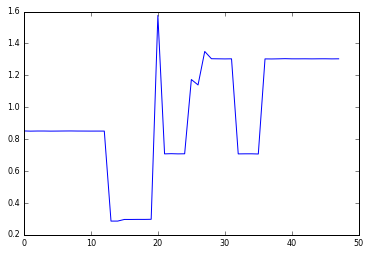

In [215]:
plot(range(48), demand0 + res3.x)

In [216]:
# one home example --- show how to two targets
print 'original aggregated demand shape: ', aggregated_load.shape
print 'original demand shape: ', oriDe.shape
new_demand_container = np.zeros((oriDe.shape[0], oriDe.shape[1], oriDe.shape[2]))
new_demand_container2 = np.zeros((oriDe.shape[0], oriDe.shape[1], oriDe.shape[2]))
new_demand_container3 = np.zeros((oriDe.shape[0], oriDe.shape[1], oriDe.shape[2]))
oldcost = 0
newcost = 0
oldcost1 = 0
newcost1 = 0
oldcost2 = 0
newcost2 = 0
oldcost3 = 0
newcost3 = 0
for cus in range(oriDe.shape[0]):
    for date in range(oriDe.shape[1]):
        demand = oriDe[cus, date, :]
        if np.random.rand() < penetration_rate:
            res = optim(demand)
            new_demand = demand + res.x
            new_demand_container[cus,date,:] = new_demand
            oldcost = objcal(0, demand)
            newcost = objcal(res.x, demand)
            oldcost1 = oldcost1 + oldcost
            newcost1 = newcost1 + newcost
            newlimit = 0.7*newcost + 0.3*oldcost
            wc = WaveletClass(demand, 'haar', 'constant', 4)
            wc.decompose()
            (tmp1, tmp2, tmp3) = wc.get_uncertainty(3)
            change = tmp2 + tmp3
            res2 = optim2(demand, change, newlimit)
            res3 = optim3(demand0, 0.3*objcal(0, demand0) + 0.7*objcal(res.x, demand0))
            new_demand2 = demand + res2.x
            new_demand_container2[cus,date,:] = new_demand2
            new_demand3 = demand + res3.x
            new_demand_container3[cus,date,:] = new_demand3
            oldcost2 = oldcost2 + objcal(0, demand)
            newcost2 = newcost2 + objcal(res2.x, demand)
            oldcost3 = oldcost3 + objcal(0, demand)
            newcost3 = newcost3 + objcal(res3.x, demand)
            print oldcost, newcost, newcost2, newcost3
        else:
            new_demand = demand
            new_demand2 = demand
            new_demand3 = demand
            new_demand_container[cus,date,:] = new_demand
            new_demand_container2[cus,date,:] = new_demand2
            new_demand_container3[cus,date,:] = new_demand3
        print 'cus = ',cus,', date index = ',date
aggregated_new_load = np.mean(new_demand_container, axis = 0)
aggregated_new_load2 = np.mean(new_demand_container2, axis = 0)
aggregated_new_load3 = np.mean(new_demand_container3, axis = 0)

original aggregated demand shape:  (7, 48)
original demand shape:  (100, 7, 48)
cus =  0 , date index =  0
cus =  0 , date index =  1
401.389225 339.561605 358.109891 355.591109896
cus =  0 , date index =  2
cus =  0 , date index =  3
cus =  0 , date index =  4
512.53251 441.25245 820.746359 818.227577896
cus =  0 , date index =  5
cus =  0 , date index =  6
cus =  1 , date index =  0
cus =  1 , date index =  1
979.942855 881.010195 1731.436352 1728.9175709
cus =  1 , date index =  2
cus =  1 , date index =  3
cus =  1 , date index =  4
1550.501525 1436.493985 3202.132599 3199.6138179
cus =  1 , date index =  5
cus =  1 , date index =  6
cus =  2 , date index =  0
1348.613415 1221.821335 4461.991558 4459.4727769
cus =  2 , date index =  1
cus =  2 , date index =  2
cus =  2 , date index =  3
cus =  2 , date index =  4
cus =  2 , date index =  5
cus =  2 , date index =  6
cus =  3 , date index =  0
cus =  3 , date index =  1
cus =  3 , date index =  2
cus =  3 , date index =  3
cus =  3

(7, 48)
Original network uncertainty:  0.0711227648678
after optimization
Original network uncertainty:  0.0760807199775
Original network uncertainty:  0.0670164621689
Original network uncertainty:  0.0979857336511
oldcost for whole network:  110400.140085
newcost (prior EMS):  99829.50093
newcost (proposed EMS):  103000.657773
newcost (smooth EMS):  102563.866702
cost reduction proposed EMS:  6.70 %
cost reduction smooth EMS:  7.10 %
uncertainty reduction (prior EMS): -6.97 %
uncertainty reduction (proposed EMS):  5.77 %
uncertainty reduction (smooth EMS):-37.77 %
uncertainty reduction improvement vs prior EMS: 11.91 %
uncertainty reduction improvement vs smooth EMS: 31.61 %


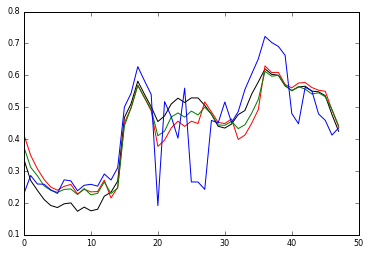

In [217]:
print aggregated_load.shape
plot(range(48), np.mean(aggregated_load, axis = 0), 'black')
plot(range(48), np.mean(aggregated_new_load, axis = 0), 'r')
plot(range(48), np.mean(aggregated_new_load2, axis = 0), 'g')
plot(range(48), np.mean(aggregated_new_load3, axis = 0), 'b')
olduc = cal_network_uc(aggregated_load)
print 'after optimization'
newuc = cal_network_uc(aggregated_new_load)
newuc2 = cal_network_uc(aggregated_new_load2)
newuc3 = cal_network_uc(aggregated_new_load3)
print 'oldcost for whole network: ', oldcost2
print 'newcost (prior EMS): ', newcost1
print 'newcost (proposed EMS): ', newcost2
print 'newcost (smooth EMS): ', newcost3
print 'cost reduction proposed EMS:{:6.2f}'.format(100*(oldcost2 - newcost2)/oldcost2),'%'
print 'cost reduction smooth EMS:{:6.2f}'.format(100*(oldcost3 - newcost3)/oldcost3),'%'
print 'uncertainty reduction (prior EMS):{:6.2f}'.format(100*(olduc - newuc)/olduc),'%'
print 'uncertainty reduction (proposed EMS):{:6.2f}'.format(100*(olduc - newuc2)/olduc),'%'
print 'uncertainty reduction (smooth EMS):{:6.2f}'.format(100*(olduc - newuc3)/olduc),'%'
print 'uncertainty reduction improvement vs prior EMS:{:6.2f}'.format(100*(newuc - newuc2)/newuc),'%'
print 'uncertainty reduction improvement vs smooth EMS:{:6.2f}'.format(100*(newuc3 - newuc2)/newuc3),'%'

In [218]:
time2 = time.time()
print time2 - time1

76188.2392521
